In [11]:
import numpy as np
import matplotlib.pyplot as plt
from variogramfitnew import variogramfit
from krigingnew import kriging
from a_star_alg import a_star_path

In [14]:
def build_experimental_variogram(x, y, values, bins=10, max_dist=None):
    from scipy.spatial.distance import pdist # pairwise euclidean distance between points

    coords = np.column_stack((x, y)) # combine x,y into single 2D array shape
    dists = pdist(coords)
    diffs = pdist(values.reshape(-1, 1)) ** 2 / 2 # Reshape: makes sure values r column vector, **2/2 for computing semivariance

    if max_dist is None:
        max_dist = np.max(dists) * 0.7 #ignore outlierrs that arer more than 70% of the max distance

    bin_edges = np.linspace(0, max_dist, bins + 1)# Bin edges into equal-length intervals
    bin_indices = np.digitize(dists, bin_edges)# bin_indices maps each pair to a bin.

    h, gamma, numobs = [], [], [] # avg distance of the bin, avg semivariance(y-axis of varigram), number of point-pairs in the bin
    for i in range(1, bins + 1):
        mask = bin_indices == i
        if np.any(mask):
            h.append(np.mean(dists[mask]))
            gamma.append(np.mean(diffs[mask]))
            numobs.append(np.sum(mask))

    return np.array(h), np.array(gamma), np.array(numobs)

In [15]:
def load_sensor_data(filename):
    sensor_data = []
    with open(filename, "r") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) != 7:
                continue  # skip malformed lines
            vwc, temp, ec = map(float, parts[0:3])
            lon = float(parts[3])
            lat = float(parts[4])
            timestamp = parts[5]
            robot_id = parts[6]
            sensor_data.append((vwc, temp, ec, f"{lon} {lat}", timestamp, robot_id))
    return sensor_data

In [16]:
def grid_to_longlat(i, j, grid_shape, lon_min, lon_max, lat_min, lat_max):
    nx, ny = grid_shape
    lon = lon_min + (lon_max - lon_min) * (j / (nx - 1))
    lat = lat_min + (lat_max - lat_min) * (i / (ny - 1))
    return lon, lat

In [17]:
def kriging_traverse_maze(file: str, grid_shape: tuple = (50, 50)):
    sensor_data = load_sensor_data(file)

    # Extract x (lon), y (lat), vwc values
    x, y, vwc = [], [], []
    for v, temp, ec, coord_str, time_str, robot_id in sensor_data:
        lon, lat = map(float, coord_str.strip().split())
        x.append(lon)
        y.append(lat)
        vwc.append(float(v))

    x = np.array(x)
    y = np.array(y)
    vwc = np.array(vwc)

    lon_min, lon_max = np.min(x), np.max(x)
    lat_min, lat_max = np.min(y), np.max(y)
    #print(f"Longitude range: {lon_min} to {lon_max}")
    #print(f"Latitude range: {lat_min} to {lat_max}")

    # Experimental variogram
    h, gammaexp, numobs = build_experimental_variogram(x, y, vwc)

    # Variogram fitting
    a, c, nugget, vstruct = variogramfit(
        h, gammaexp, numobs=numobs, model="spherical", nugget=0.05, plotit=False
    )

    # Grid setup for kriging
    grid_x_vals = np.linspace(lon_min, lon_max, grid_shape[0])
    grid_y_vals = np.linspace(lat_min, lat_max, grid_shape[1])
    grid_x, grid_y = np.meshgrid(grid_x_vals, grid_y_vals)

    # Kriging
    mean_map, var_map = kriging(vstruct, x, y, vwc, grid_x, grid_y)

    # Robot goal selection
    next_goals = {}
    for robot_id in set(entry[5] for entry in sensor_data):
        recent_entry = next(e for e in reversed(sensor_data) if e[5] == robot_id)
        lon, lat = map(float, recent_entry[3].strip().split())

        i = np.abs(grid_x_vals - lon).argmin()
        j = np.abs(grid_y_vals - lat).argmin()
        current = (j, i)

        target = np.unravel_index(np.argmax(var_map), var_map.shape)

        try:
            path = a_star_path(current, target, var_map)
            if len(path) > 1:
                next_goals[robot_id] = path[1]
            else:
                next_goals[robot_id] = target
        except Exception as e:
            print(f"Path planning failed for robot {robot_id}: {e}")
            next_goals[robot_id] = target

    return var_map, next_goals, (lon_min, lon_max, lat_min, lat_max)


Next Robot Goals:
Robot 0 → Cell (48, 0) → GPS (-74.172800, 40.853000)

Next Robot Goals:
Robot 0 → Cell (48, 0) → GPS (-74.172800, 41.338333)

Next Robot Goals:
Robot 0 → Cell (48, 0) → GPS (-74.172800, 43.926776)

Next Robot Goals:
Robot 0 → Cell (48, 0) → GPS (-74.172800, 57.731805)

Next Robot Goals:
Robot 0 → Cell (48, 0) → GPS (-74.172800, 131.358627)


Text(0, 0.5, 'Y grid')

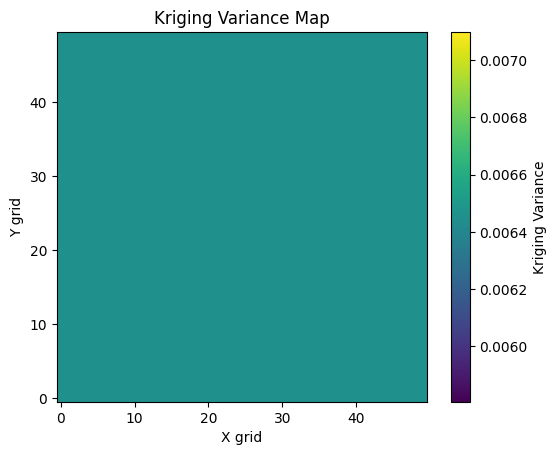

In [19]:
num_runs=5;
while num_runs>0:
    var_map, next_goals, bounds = kriging_traverse_maze("sensorData.txt")
    lon_min, lon_max, lat_min, lat_max = bounds
    
    print("\nNext Robot Goals:")
    for robot, (i, j) in next_goals.items():
        lon, lat = grid_to_longlat(i, j, (10, 10), lon_min, lon_max, lat_min, lat_max)
        print(f"Robot {robot} → Cell ({i}, {j}) → GPS ({lon:.6f}, {lat:.6f})")
        with open("sensorData.txt", "a") as file:
            file.write(f"0.22,24.7,1.3,{lon:.6f},{lat:.6f},15:08:00,0\n")
        #print(f"0.22,24.7,1.3,{lon:.6f},{lat:.6f},15:08:00,0")
        #FIX
        with open("db.txt", 'r') as db:
            lines = db.readlines()
    
        robot_found = False
        for i, line in enumerate(lines):
            if line.startswith(robot + ","):
                lines[i] = f"{robot},{lon},{lat}\n"
                robot_found = True
                break
        # If the robot was not found, append a new line
        if not robot_found:
            lines.append(f"{robot},{lon},{lat}\n")
        # Write the updated lines back to db.txt
        with open("db.txt", 'w') as db:
            db.writelines(lines)
    num_runs = num_runs-1

plt.imshow(var_map, origin="lower", cmap="viridis")
plt.colorbar(label="Kriging Variance")
plt.title("Kriging Variance Map")
plt.xlabel("X grid")
plt.ylabel("Y grid")